# Milestone 2
**Ryan Schell and Tyler Brown**

Again both members contributed fairly equally to this assignment. Ryan worked more on the functions for the absolute error, the gathering of the ECMWF and ECMWF AI data, and the creation of the RMSE plots for the various ECMWF amd ECMWF AI. Tyler worked more on the documentation, the creation of the various range maps, and the initial RMSE data. We both did work with everything though to ensure every step was completed, and both had to run through the notebook many times which took a painfully long time to run.

## Gathering Data

Import statements

In [1]:
from herbie import Herbie, FastHerbie
import pandas as pd, numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import cartopy.crs as ccrs, cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from copy import copy
from matplotlib.colors import ListedColormap, BoundaryNorm

Import the data from our specified run date: 2024-10-10 at 0 UTC 
Only gather surface pressure, as specified from the 'msl' in the ss line. This will give us pressure data for the US in Pascals

In [13]:
save_dir = '~/meteo473_groupwork/group5/data/tyler'
run = pd.Timestamp("2024-10-10", tz="utc").replace(tzinfo=None).floor('24h')
H = FastHerbie([run], model="ifs", product="oper", fxx=np.arange(0,246,6).tolist(), save_dir=save_dir)

In [14]:
ss = r":msl:"
ds = H.xarray(ss)
ds
# REMEBER UNITS ARE PASCALS

👨🏻‍🏭 Created directory: [/home/meteo/trb5674/meteo473_groupwork/group5/data/tyler/ifs/20241010]


<xarray.Dataset> Size: 170MB
Dimensions:              (step: 41, latitude: 721, longitude: 1440)
Coordinates:
    time                 datetime64[ns] 8B 2024-10-10
  * step                 (step) timedelta64[ns] 328B 0 days 00:00:00 ... 10 d...
    meanSea              float64 8B 0.0
  * latitude             (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude            (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    valid_time           (step) datetime64[ns] 328B 2024-10-10 ... 2024-10-20
    gribfile_projection  object 8B None
Data variables:
    msl                  (step, latitude, longitude) float32 170MB 1.023e+05 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ifs
    product:                 oper
    description:             ECMWF Open Data - Integrated Forecast System
    search:                  :msl:

## Finding Absolute Error

Now we will do what we did in milestone 1, where we will take the forecast data from our model we ran above, and then take the verified data from the new run ran at the specified time. Through the functions model_data and varify_data we can get all that data without having too much code or repitition. Finally we can use the forecast and verified data to find our absolute error. That will be done by subtracting the forecast data by the verified data, and then appending each hour's absolute error into a list so we can get all the errors in one spot.

In [15]:
def model_data(dsf, time_step):
    dss = dsf.isel(step=time_step)
    msl_val = dss['msl'].values
    return msl_val

def varify_data(dsf, step_num):
    test_time = dsf['valid_time'].isel(step=step_num)
    test_time = test_time['valid_time'].values
    tt_str = test_time.astype(str)
    tt_str = tt_str[:-3]
    rt = pd.Timestamp(tt_str, tz="utc").replace(tzinfo=None)
    Hf = Herbie(rt, model="ifs", product="oper", fxx=0, save_dir=save_dir, overwrite = True)
    dst = Hf.xarray(ss)
    return dst

abs_error_list= []
for i in range(0, len(ds['valid_time']), 2):
    vdata = varify_data(ds, i)
    mdata = model_data(ds, i)
    absolute_error = abs(mdata - vdata)
    abs_error_list.append(absolute_error)

✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-10 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/home/meteo/trb5674/meteo473_groupwork/group5/data/tyler/ifs/20241011]
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-11 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/home/meteo/trb5674/meteo473_groupwork/group5/data/tyler/ifs/20241012]
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-12 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/home/meteo/trb5674/meteo473_groupwork/group5/data/tyler/ifs/20241013]
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-13 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


Next, we will want to put all of the data in the absolute error list into one xarray dataset. Before that happens, we will create a new forecast error list which will go into the xarray dataset below. This forecast hour list will allow us to correspond each piece of data its specified time, which will be helpful later in our code where we want to create plots with the error corresponding to a specified time.

In [16]:
fhr_list= []
for i in range(0, len(ds['valid_time']), 2):
    fhr = i * 6
    fhr_list.append(fhr)

dse = xr.concat(abs_error_list, dim='time')
dse.coords['fhr'] = ('time', fhr_list)
dse

<xarray.Dataset> Size: 87MB
Dimensions:              (time: 21, latitude: 721, longitude: 1440)
Coordinates:
  * time                 (time) datetime64[ns] 168B 2024-10-10 ... 2024-10-20
    step                 timedelta64[ns] 8B 00:00:00
    meanSea              float64 8B 0.0
  * latitude             (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude            (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    valid_time           (time) datetime64[ns] 168B 2024-10-10 ... 2024-10-20
    gribfile_projection  object 8B None
    fhr                  (time) int64 168B 0 12 24 36 48 ... 192 204 216 228 240
Data variables:
    msl                  (time, latitude, longitude) float32 87MB 0.0 ... 949.8
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ifs
    product:                 oper
    description:             ECMWF Open Data - Integrated Forecast System
    remote_grib:             https://ecmwf-forecasts.s3.eu-central-1.amazonaw...
    local_grib:              /home/meteo/trb5674/meteo473_groupwork/group5/da...
    search:                  :msl:

Finally we can plot the absolute error below using a function to create and display the data. Since the data is in pascals first it is all converted to hectopascals and then it is plotted on a chart with the absolute difference on the y axis and the forecast hours on the x axis. The absolute error data will match to its corresponding forecast error which will allow us to observe the error as we move forward in time.

<Axes: title={'center': 'Absolute Difference at Latitude: 40.7 and Longitude: -77.8'}, xlabel='Forecast Hour', ylabel='Absolute Difference (hPa)'>

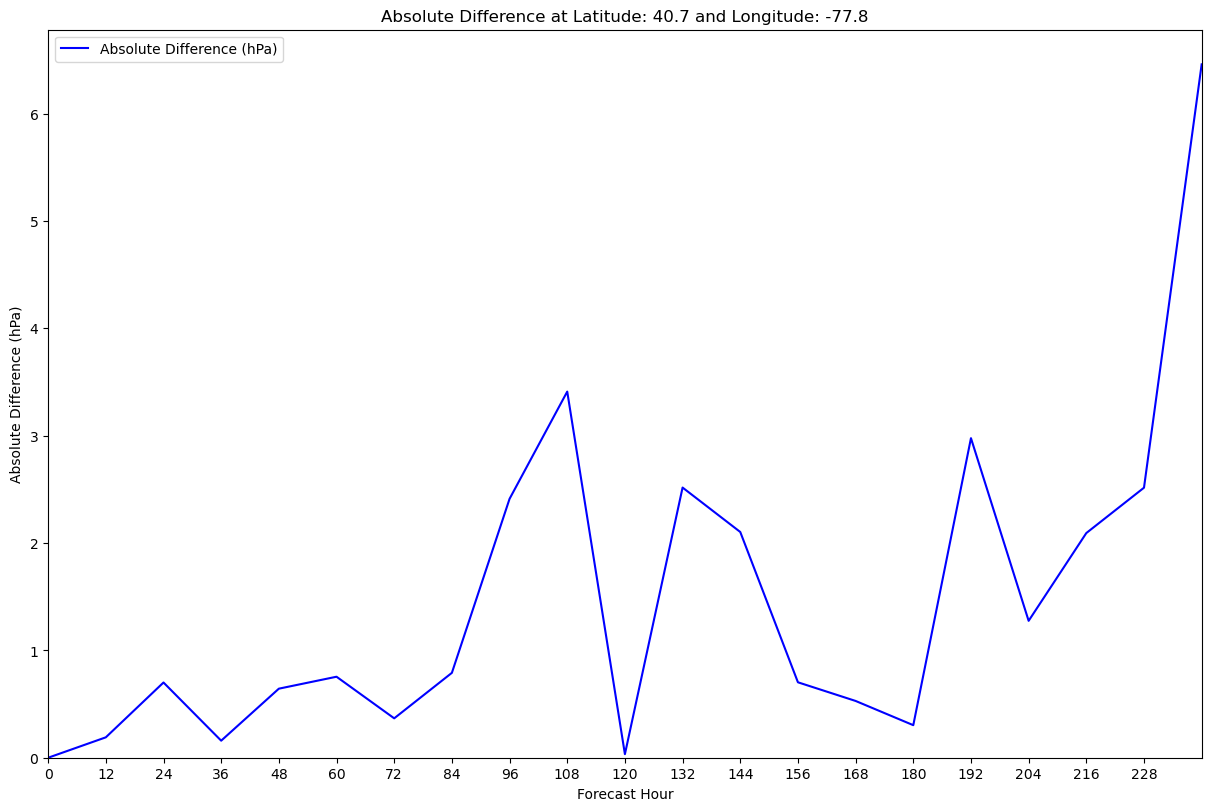

In [17]:
def forecast_abs_error(lat, lon, subplot_pos):
    fig = plt.figure(figsize=(12, 8),  constrained_layout = True)
    ax = fig.add_subplot(subplot_pos)

    dsst = dse.sel(method = 'nearest', latitude = lat, longitude = lon)
    msl_error = dsst['msl'].values
    msl_error_hPa = msl_error / 100

    fhr_graph = dsst['fhr'].values

    plt.plot(fhr_graph, msl_error_hPa, color='b', label='Absolute Difference (hPa)')
    plt.title(f'Absolute Difference at Latitude: {lat} and Longitude: {lon}')
    plt.xlabel('Forecast Hour')
    plt.xlim(0, fhr_graph[-1])
    plt.xticks(np.arange(0, fhr_graph[-1], 12))
    plt.ylabel('Absolute Difference (hPa)')
    plt.ylim(bottom = 0)
    plt.legend(loc = 'upper left')
    return ax

forecast_abs_error(40.7, -77.8, 111)

## Mean Absolute Error by Range
Now we want to find the mean absoulte error for the short, medium, and long range timesets, and plot that data on maps. This can be done by first separating all the data into different ranges, with short range being hour 12-60, medium range being hour 72-144, and long range being hour 154-240. This will provide us with three datasets of the absoulte error. Then we'll take the mean for each of the three datasets, which will allow us to plot all of the data on each respective maps. In the second cell we just have all the data and function to set up a cartopy map, and then we overlayed each range onto a seperate contour map. While all three maps look similar, it is clear as you go on in time the error does get worse which would make sense. Also, it seems the greatest error is in the plains, in Canada, and over the Atlantic ocean, which is interesting.

In [18]:
dse_sr = dse.sel(latitude=slice(60,20), longitude=slice(-125,-65))
dse_sr = dse.isel(time=slice(1,6))
dse_sr_mean = dse_sr.mean(dim='time')

dse_mr = dse.sel(latitude=slice(60,20), longitude=slice(-125,-65))
dse_mr = dse.isel(time=slice(6,13))
dse_mr_mean = dse_mr.mean(dim='time')

dse_lr = dse.sel(latitude=slice(60,20), longitude=slice(-125,-65))
dse_lr = dse.isel(time=slice(13,21))
dse_lr_mean = dse_lr.mean(dim='time')

sr_mean = dse_sr_mean['msl'].values
mr_mean = dse_mr_mean['msl'].values
lr_mean = dse_lr_mean['msl'].values

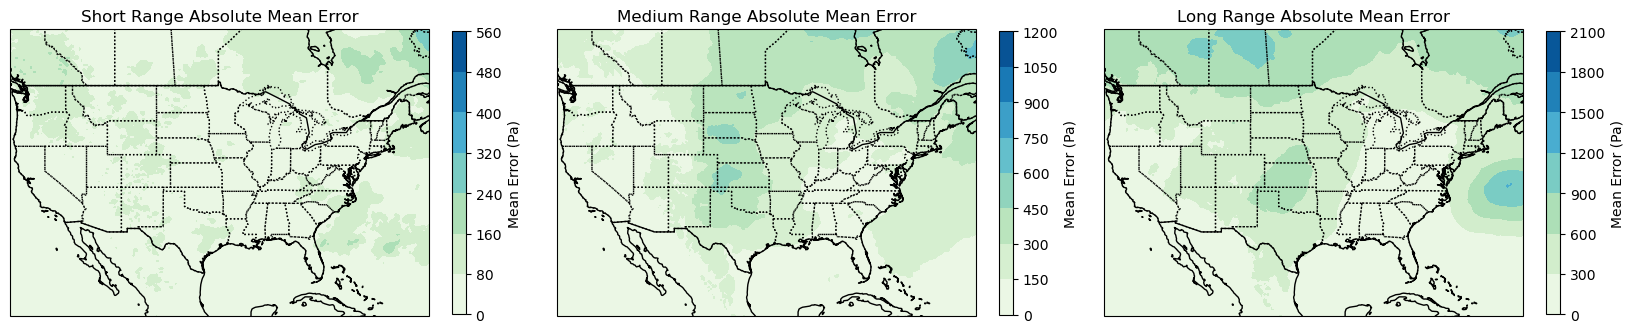

In [19]:
dataproj = ccrs.PlateCarree()
lat = dse_sr.latitude.values
lon = dse_sr.longitude.values

def create_map(title, subplot_pos):
    ax = fig.add_subplot(subplot_pos, projection=ccrs.Miller())
    ax.set_extent([-125,-65,20,55], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    ax.set_title(title)
    return ax


fig = plt.figure(figsize=(20, 15))
ax1 = create_map(f'Short Range Absolute Mean Error', 131)
ax2 = create_map(f'Medium Range Absolute Mean Error', 132)
ax3 = create_map(f'Long Range Absolute Mean Error', 133)


sr_plot = ax1.contourf(lon, lat, sr_mean, cmap = 'GnBu', transform=dataproj)
im1_ratio = sr_mean.shape[0]/sr_mean.shape[1]
cbar1 = plt.colorbar(sr_plot, ax=ax1, label='Mean Error (Pa)', fraction=0.062*im1_ratio)
mr_plot = ax2.contourf(lon, lat, mr_mean, cmap = 'GnBu', transform=dataproj)
cbar2 = plt.colorbar(mr_plot, ax=ax2, label='Mean Error (Pa)', fraction=0.062*im1_ratio)
lr_plot = ax3.contourf(lon, lat, lr_mean, cmap = 'GnBu', transform=dataproj)
cbar3 = plt.colorbar(lr_plot, ax=ax3, label='Mean Error (Pa)', fraction=0.062*im1_ratio)

## Root Mean Square Error
Through a few lines of code, we can run out the root mean square error equation, and through a for loop, we can find the RMSE for every forecast. All of this data will be placed in a list (rmse_list) where it will be used to create the plot of the RMSE across all forecast hours. Through the forecast hour function we made back for absolute error, we can connect each RMSE to a forecast error which allows us to plot it all on a line graph as seen below.

In [20]:
rmse_list= []
for i in range(0, len(dse['time']), 1):
    dss = dse.isel(time=i) 
    diff = dss['msl'].values
    mean_squared_error = ((diff)**2).mean()
    rmse = np.sqrt(mean_squared_error)
    rmse_list.append(rmse)

<Axes: title={'center': 'Root Mean Square Error Across All Forecast Hours'}, xlabel='Forecast Hour', ylabel='Root Mean Square Error (Pa)'>

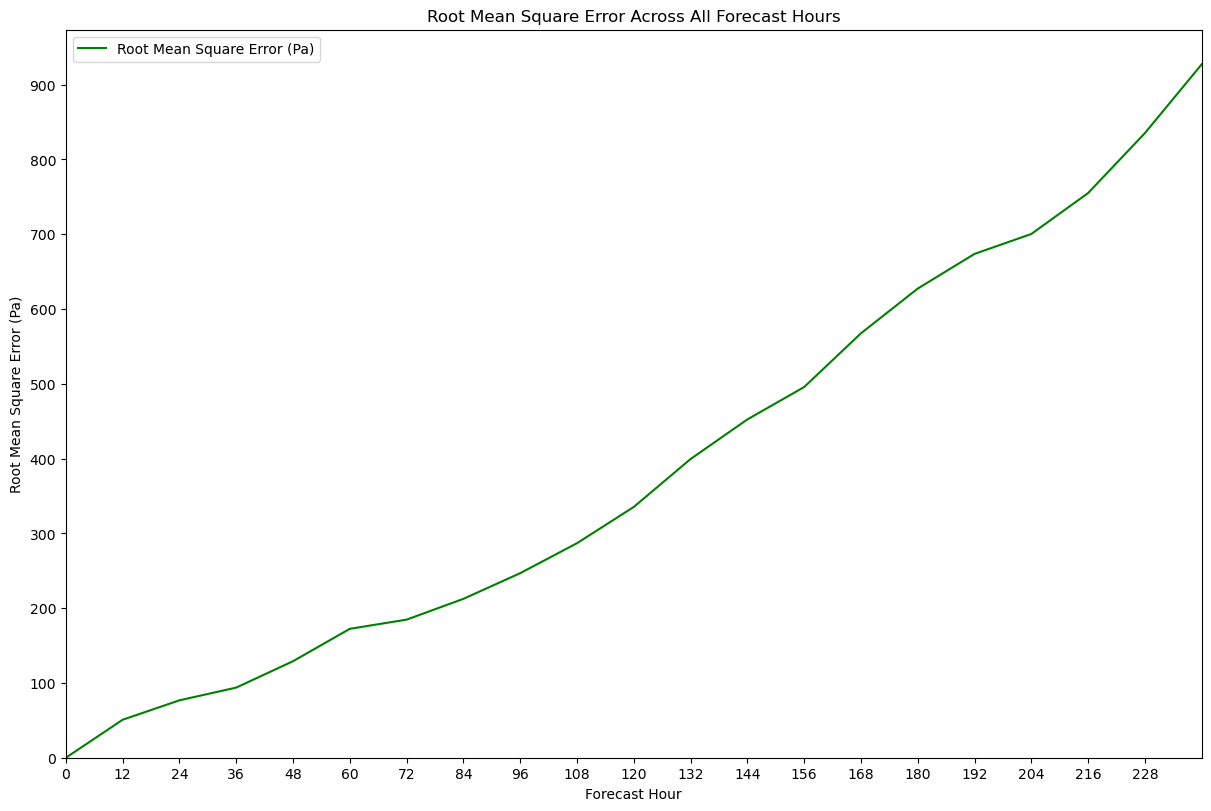

In [21]:
def rmse_plot(subplot_pos):
    fig = plt.figure(figsize=(12, 8),  constrained_layout = True)
    ax = fig.add_subplot(subplot_pos)

    fhr_graph = dse['fhr'].values
    
    plt.plot(fhr_graph, rmse_list, color='g', label='Root Mean Square Error (Pa)')
    plt.title(f'Root Mean Square Error Across All Forecast Hours')
    plt.xlabel('Forecast Hour')
    plt.xlim(0, fhr_graph[-1])
    plt.xticks(np.arange(0, fhr_graph[-1], 12))
    plt.ylabel('Root Mean Square Error (Pa)')
    plt.ylim(bottom = 0)
    plt.yticks(np.arange(0, 1000, 100))
    plt.legend(loc = 'upper left')
    return ax

rmse_plot(111)

## RMSE for Multiple Forecast Hours

In the first cell below we created a function to download the data from 9 other runs, giving us 10 in total. This will allow us to compare the error and ultimately the RMSE for different forecast hours. In the second cell simply use the run_data function to grab the data for each hour we want. Unfortunately this will take some time, but it will provide solid data once all downloaded. 

In [22]:
def run_data(twelve_hour_period):
    hour = 12 * twelve_hour_period
    new_run = run + timedelta(hours=hour)
    Hr = FastHerbie([new_run], model="ifs", product="oper", fxx=np.arange(0,246,6).tolist(), save_dir=save_dir)
    ss = r":msl:"
    dssh = Hr.xarray(ss)
    abs_error_list_h= []
    for i in range(0, len(dssh['valid_time']), 2):
        vdata = varify_data(dssh, i)
        mdata = model_data(dssh, i)
        absolute_error = abs(mdata - vdata)
        abs_error_list_h.append(absolute_error)
    fhr_list_h= []
    for i in range(0, len(dssh['valid_time']), 2):
        fhr = i * 6
        fhr_list_h.append(fhr)
    dsh = xr.concat(abs_error_list_h, dim='time')
    dsh.coords['fhr'] = ('time', fhr_list_h)
    return dsh

In [23]:
dsh1 = run_data(1)
dsh2 = run_data(2)
dsh3 = run_data(3)
dsh4 = run_data(4)
dsh5 = run_data(5)
dsh6 = run_data(6)
dsh7 = run_data(7)
dsh8 = run_data(8)
dsh9 = run_data(9)

✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-10 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-11 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-12 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-13 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-14 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-15 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊

Once all the runs are downloaded above, we can create a RMSE plot with all 10 forecast runs. This will allow us to see how accurate the ECMWF is over different runs, and with a mean line we can see how far the runs deviate from each other. The greater the deviation, the more variability in the runs. Before we get to that cell however we have one sell with a variety of different things which turn our data into lists that can be plotted and allow us to find the mean. The time_list function also allows the x axis of the chart below to have the proper forecast hours.

In [26]:
def rmse_list_run(dsh):
    rmse_list_h= []
    for i in range(0, len(dsh['time']), 1):
        dssh = dsh.isel(time=i) 
        diff_h = dssh['msl'].values
        mean_squared_error_h = ((diff_h)**2).mean()
        rmse_h = np.sqrt(mean_squared_error_h)
        rmse_list_h.append(rmse_h)
    return rmse_list_h

rmse_list_h1 = rmse_list_run(dsh1)
rmse_list_h2 = rmse_list_run(dsh2)
rmse_list_h3 = rmse_list_run(dsh3)
rmse_list_h4 = rmse_list_run(dsh4)
rmse_list_h5 = rmse_list_run(dsh5)
rmse_list_h6 = rmse_list_run(dsh6)
rmse_list_h7 = rmse_list_run(dsh7)
rmse_list_h8 = rmse_list_run(dsh8)
rmse_list_h9 = rmse_list_run(dsh9)


combined_rmse_list = np.array([rmse_list, rmse_list_h1, rmse_list_h2, rmse_list_h3, rmse_list_h4, rmse_list_h5, rmse_list_h6, rmse_list_h7, rmse_list_h8, rmse_list_h9])
mean_values = np.mean(combined_rmse_list, axis=0)
# Code in these two lines was found with Google AI

time_list = []
for i in range(0, 10, 1):
    hour = 12 * i
    new_run = run + timedelta(hours=hour)
    formatted_nr = new_run.strftime('%m-%d-%Y %Hz')
    time_list.append(formatted_nr)

<Axes: title={'center': 'Root Mean Square Error Across All Forecast Hours'}, xlabel='Forecast Hour', ylabel='Root Mean Square Error (Pa)'>

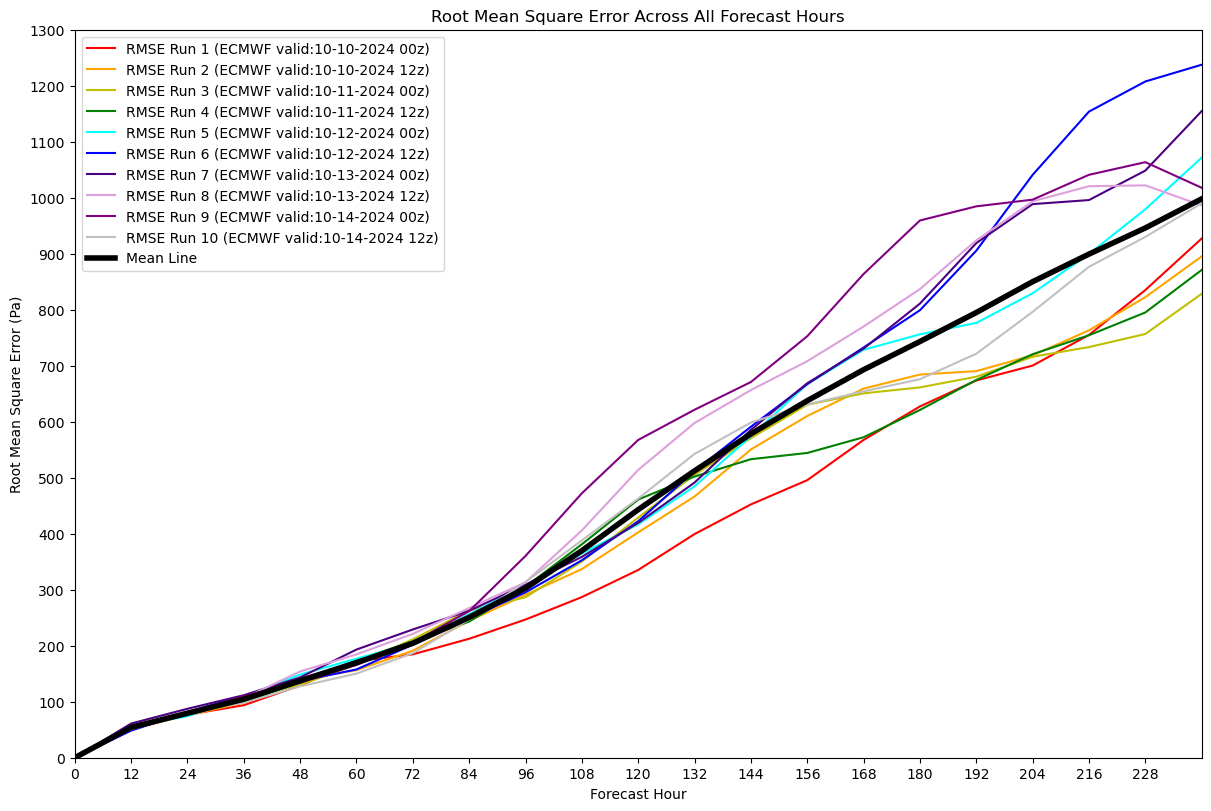

In [28]:
def rmse_plot(subplot_pos):
    fig = plt.figure(figsize=(12, 8),  constrained_layout = True)
    ax = fig.add_subplot(subplot_pos)

    fhr_graph = dse['fhr'].values
    
    plt.plot(fhr_graph, rmse_list, color='r', label=f'RMSE Run 1 (ECMWF valid:{time_list[0]})')
    plt.plot(fhr_graph, rmse_list_h1, color='orange', label=f'RMSE Run 2 (ECMWF valid:{time_list[1]})')
    plt.plot(fhr_graph, rmse_list_h2, color='y', label=f'RMSE Run 3 (ECMWF valid:{time_list[2]})')
    plt.plot(fhr_graph, rmse_list_h3, color='g', label=f'RMSE Run 4 (ECMWF valid:{time_list[3]})')
    plt.plot(fhr_graph, rmse_list_h4, color='cyan', label=f'RMSE Run 5 (ECMWF valid:{time_list[4]})')
    plt.plot(fhr_graph, rmse_list_h5, color='b', label=f'RMSE Run 6 (ECMWF valid:{time_list[5]})')
    plt.plot(fhr_graph, rmse_list_h6, color='indigo', label=f'RMSE Run 7 (ECMWF valid:{time_list[6]})')
    plt.plot(fhr_graph, rmse_list_h7, color='plum', label=f'RMSE Run 8 (ECMWF valid:{time_list[7]})')
    plt.plot(fhr_graph, rmse_list_h8, color='purple', label=f'RMSE Run 9 (ECMWF valid:{time_list[8]})')
    plt.plot(fhr_graph, rmse_list_h9, color='silver', label=f'RMSE Run 10 (ECMWF valid:{time_list[9]})')
    plt.plot(fhr_graph, mean_values, color='k', linewidth=4, label='Mean Line')
    plt.title(f'Root Mean Square Error Across All Forecast Hours')
    plt.xlabel('Forecast Hour')
    plt.xlim(0, fhr_graph[-1])
    plt.xticks(np.arange(0, fhr_graph[-1], 12))
    plt.ylabel('Root Mean Square Error (Pa)')
    plt.ylim(bottom = 0)
    plt.yticks(np.arange(0, 1400, 100))
    plt.legend(loc = 'upper left')
    return ax

rmse_plot(111)

## RMSE for the ECMWF AI

Now we're going to grab data from the ECMWF AI model runs from the same forecast hours as above, and we'll use the same functions (just adjusted for the Euro AI) to get the RMSE. Then we can compare this to the actual ECMWF and see which model is more accurate over time.

In [29]:
def model_data_ai(dsf, time_step):
    dssa = dsf.isel(step=time_step)
    msl_val = dssa['msl'].values
    return msl_val

def varify_data_ai(dsf, step_num):
    test_time = dsf['valid_time'].isel(step=step_num)
    test_time = test_time['valid_time'].values
    tt_str = test_time.astype(str)
    tt_str = tt_str[:-3]
    rt = pd.Timestamp(tt_str, tz="utc").replace(tzinfo=None)
    Hf = Herbie(rt, model="aifs", product="oper", fxx=0, save_dir=save_dir)
    dst = Hf.xarray(ss)
    return dst


In [30]:
def run_data_ai(twelve_hour_period):
    hour = 12 * twelve_hour_period
    new_run = run + timedelta(hours=hour)
    Hra = FastHerbie([new_run], model="aifs", product="oper", fxx=np.arange(0,246,6).tolist(), save_dir=save_dir)
    ss = r":msl:"
    dssh = Hra.xarray(ss)
    abs_error_list_h= []
    for i in range(0, len(dssh['valid_time']), 2):
        vdata = varify_data_ai(dssh, i)
        mdata = model_data_ai(dssh, i)
        absolute_error = abs(mdata - vdata)
        abs_error_list_h.append(absolute_error)
    fhr_list_h= []
    for i in range(0, len(dssh['valid_time']), 2):
        fhr = i * 6
        fhr_list_h.append(fhr)
    dsh = xr.concat(abs_error_list_h, dim='time')
    dsh.coords['fhr'] = ('time', fhr_list_h)
    return dsh

In [31]:
dsh_ai = run_data_ai(0)
dsh1_ai = run_data_ai(1)
dsh2_ai = run_data_ai(2)
dsh3_ai = run_data_ai(3)
dsh4_ai = run_data_ai(4)
dsh5_ai = run_data_ai(5)
dsh6_ai = run_data_ai(6)
dsh7_ai = run_data_ai(7)
dsh8_ai = run_data_ai(8)
dsh9_ai = run_data_ai(9)

👨🏻‍🏭 Created directory: [/home/meteo/trb5674/meteo473_groupwork/group5/data/tyler/aifs/20241010]
✅ Found ┊ model=aifs ┊ product=oper ┊ 2024-Oct-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=aifs ┊ product=oper ┊ 2024-Oct-10 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=aifs ┊ product=oper ┊ 2024-Oct-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/home/meteo/trb5674/meteo473_groupwork/group5/data/tyler/aifs/20241011]
✅ Found ┊ model=aifs ┊ product=oper ┊ 2024-Oct-11 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=aifs ┊ product=oper ┊ 2024-Oct-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/home/meteo/trb5674/meteo473_groupwork/group5/data/tyler/aifs/20241012]
✅ Found ┊ model=aifs ┊ product=oper ┊ 2024-Oct-12 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=aifs ┊ product=oper ┊ 2024-Oct-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/home/meteo/trb5674/meteo473_groupwork/group5/data/tyl

In [32]:
rmse_list_ai = rmse_list_run(dsh_ai)
rmse_list_h1_ai = rmse_list_run(dsh1_ai)
rmse_list_h2_ai = rmse_list_run(dsh2_ai)
rmse_list_h3_ai = rmse_list_run(dsh3_ai)
rmse_list_h4_ai = rmse_list_run(dsh4_ai)
rmse_list_h5_ai = rmse_list_run(dsh5_ai)
rmse_list_h6_ai = rmse_list_run(dsh6_ai)
rmse_list_h7_ai = rmse_list_run(dsh7_ai)
rmse_list_h8_ai = rmse_list_run(dsh8_ai)
rmse_list_h9_ai = rmse_list_run(dsh9_ai)

In [33]:
combined_rmse_list_ai = np.array([rmse_list_ai, rmse_list_h1_ai, rmse_list_h2_ai, rmse_list_h3_ai, rmse_list_h4_ai, rmse_list_h5_ai, rmse_list_h6_ai, rmse_list_h7_ai, rmse_list_h8_ai, rmse_list_h9_ai])
mean_values_ai = np.mean(combined_rmse_list_ai, axis=0)

Now we can recreate our RMSE plot with the ECMWF and the ECMWF AI. The ECMWF runs will be in solid red lines while the ECMWF AI will be in dashed blue lines. Through this plot we can see which model tends to be more accurate and which one sees more errors as we move farther into the future.

<Axes: title={'center': 'Root Mean Square Error Across All Forecast Hours'}, xlabel='Forecast Hour', ylabel='Root Mean Square Error (Pa)'>

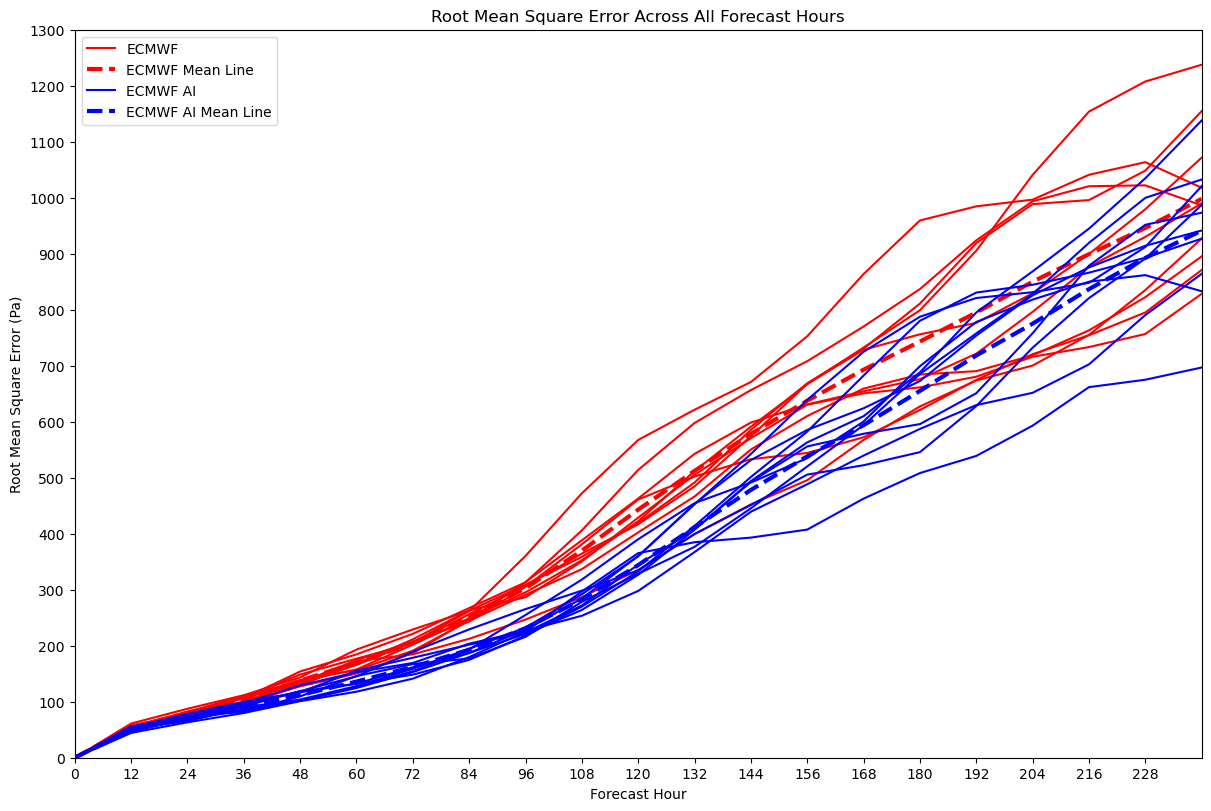

In [34]:
def rmse_plot_ecmwf_ai(subplot_pos):
    fig = plt.figure(figsize=(12, 8),  constrained_layout = True)
    ax = fig.add_subplot(subplot_pos)

    fhr_graph = dse['fhr'].values
    
    plt.plot(fhr_graph, rmse_list, color='r', label='ECMWF')
    plt.plot(fhr_graph, rmse_list_h1, color='r')
    plt.plot(fhr_graph, rmse_list_h2, color='r')
    plt.plot(fhr_graph, rmse_list_h3, color='r')
    plt.plot(fhr_graph, rmse_list_h4, color='r')
    plt.plot(fhr_graph, rmse_list_h5, color='r')
    plt.plot(fhr_graph, rmse_list_h6, color='r')
    plt.plot(fhr_graph, rmse_list_h7, color='r')
    plt.plot(fhr_graph, rmse_list_h8, color='r')
    plt.plot(fhr_graph, rmse_list_h9, color='r')
    plt.plot(fhr_graph, mean_values, color='r', linestyle='--', linewidth=3, label='ECMWF Mean Line')
    plt.plot(fhr_graph, rmse_list_ai, color='b', label='ECMWF AI')
    plt.plot(fhr_graph, rmse_list_h1_ai, color='b')
    plt.plot(fhr_graph, rmse_list_h2_ai, color='b')
    plt.plot(fhr_graph, rmse_list_h3_ai, color='b')
    plt.plot(fhr_graph, rmse_list_h4_ai, color='b')
    plt.plot(fhr_graph, rmse_list_h5_ai, color='b')
    plt.plot(fhr_graph, rmse_list_h6_ai, color='b')
    plt.plot(fhr_graph, rmse_list_h7_ai, color='b')
    plt.plot(fhr_graph, rmse_list_h8_ai, color='b')
    plt.plot(fhr_graph, rmse_list_h9_ai, color='b')
    plt.plot(fhr_graph, mean_values_ai, color='b', linestyle='--', linewidth=3, label='ECMWF AI Mean Line')
    plt.title(f'Root Mean Square Error Across All Forecast Hours')
    plt.xlabel('Forecast Hour')
    plt.xlim(0, fhr_graph[-1])
    plt.xticks(np.arange(0, fhr_graph[-1], 12))
    plt.ylabel('Root Mean Square Error (Pa)')
    plt.ylim(bottom = 0)
    plt.yticks(np.arange(0, 1400, 100))
    plt.legend(loc = 'upper left')
    return ax

rmse_plot_ecmwf_ai(111)